# Clustering vMagnus

In [1]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import matplotlib.pyplot as plt
from fa2 import ForceAtlas2
import community
from itertools import combinations

df1 = pd.read_pickle("moviesDf4899_v1.pkl")
df2 = pd.read_pickle("moviesDf4899_v2.pkl")

frames = [df1, df2]
moviesDf = pd.concat(frames)


In [13]:
actor_column = list(moviesDf["Actors"].to_numpy())
G = nx.Graph()

# Creating the graph. 
# adding edge between all actors in a given movie
for movie_cast in actor_column:
    movie_cast = movie_cast[:5]
    G.add_nodes_from(movie_cast)
    pairs = list(combinations(movie_cast,2))
    G.add_edges_from(pairs)

In [14]:
# Extracting largest connected component
nodes = max(nx.connected_components(G), key=len)
G = G.subgraph(nodes).copy()

print(f'Stats before removing weakly connected nodes')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}\n')

# Removing nodes with very small degree
#remove = [node for node,degree in dict(G.degree()).items() if degree < 10]
#G.remove_nodes_from(remove)
      
print(f'Stats after removing weakly connected nodes')
print(f'Nodes: {G.number_of_nodes()}')
print(f'Edges: {G.number_of_edges()}')

Stats before removing weakly connected nodes
Nodes: 9697
Edges: 43080

Stats after removing weakly connected nodes
Nodes: 9697
Edges: 43080


In [15]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=True,  # Dissuade hubs
                        linLogMode=False,  # NOT IMPLEMENTED
                        adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
                        edgeWeightInfluence=1.0,

                        # Performance
                        jitterTolerance=1.0,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.0,
                        multiThreaded=False,  # NOT IMPLEMENTED

                        # Tuning
                        scalingRatio=2,
                        strongGravityMode=False,
                        gravity=1.5,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100);

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:47<00:00,  2.09it/s]

BarnesHut Approximation  took  14.52  seconds
Repulsion forces  took  32.64  seconds
Gravitational forces  took  0.06  seconds
Attraction forces  took  0.07  seconds
AdjustSpeedAndApplyForces step  took  0.29  seconds


In [26]:
d = dict(G.degree).values()
scale = 4
node_size = [degree*scale for degree in d]


[300,
 120,
 116,
 80,
 96,
 332,
 64,
 160,
 16,
 128,
 272,
 296,
 48,
 120,
 212,
 40,
 128,
 88,
 80,
 120,
 288,
 248,
 76,
 48,
 16,
 284,
 500,
 232,
 276,
 212,
 304,
 80,
 144,
 16,
 80,
 80,
 112,
 64,
 16,
 48,
 96,
 32,
 32,
 32,
 32,
 176,
 140,
 16,
 136,
 144,
 268,
 156,
 224,
 16,
 80,
 208,
 80,
 96,
 68,
 64,
 352,
 236,
 232,
 96,
 16,
 308,
 192,
 304,
 168,
 192,
 160,
 168,
 80,
 232,
 180,
 320,
 48,
 152,
 60,
 144,
 172,
 64,
 44,
 80,
 144,
 108,
 208,
 64,
 120,
 16,
 96,
 260,
 200,
 128,
 16,
 128,
 292,
 484,
 176,
 320,
 128,
 220,
 168,
 144,
 108,
 188,
 288,
 240,
 292,
 16,
 44,
 172,
 96,
 156,
 256,
 32,
 296,
 180,
 172,
 48,
 208,
 208,
 32,
 16,
 16,
 208,
 96,
 248,
 108,
 356,
 16,
 32,
 16,
 32,
 16,
 156,
 16,
 16,
 44,
 16,
 112,
 16,
 16,
 16,
 16,
 372,
 144,
 16,
 16,
 48,
 16,
 404,
 64,
 16,
 16,
 112,
 80,
 144,
 48,
 44,
 80,
 32,
 64,
 80,
 144,
 48,
 32,
 112,
 216,
 236,
 160,
 32,
 32,
 112,
 132,
 16,
 64,
 16,
 140,
 48,
 96,
 

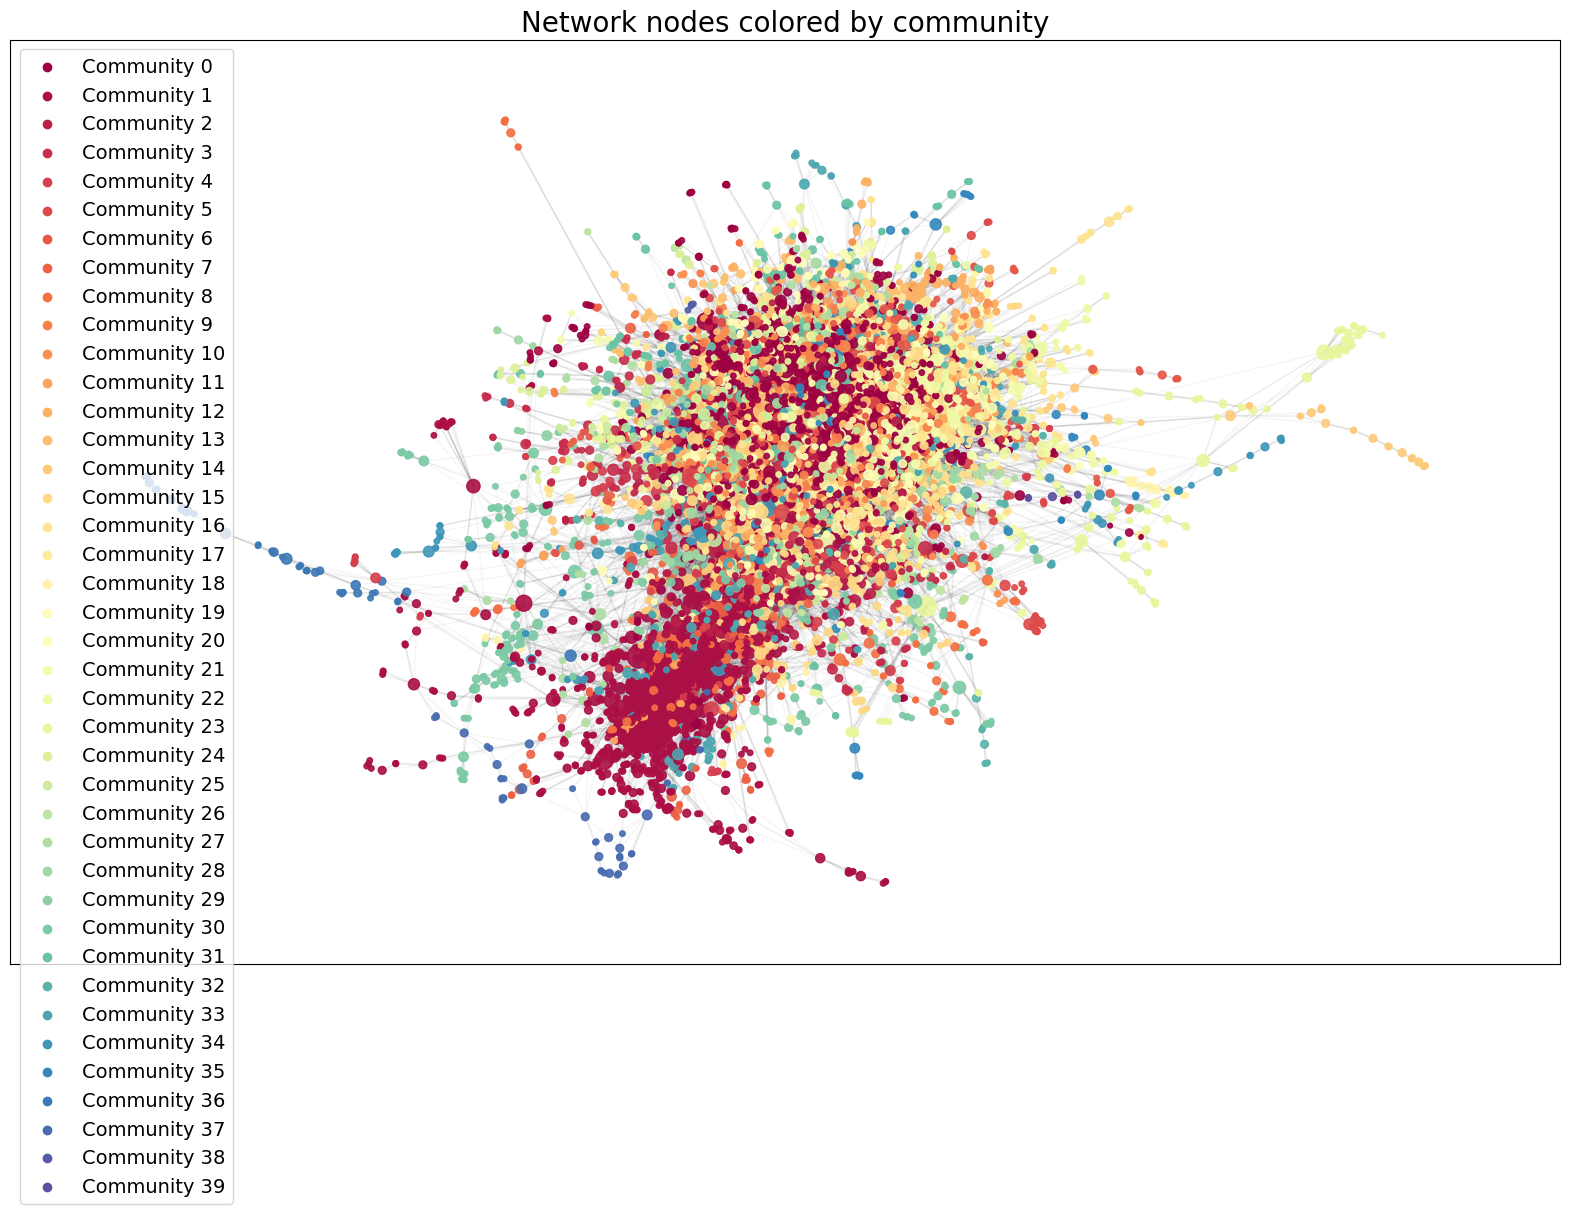

In [25]:
# Best partition found with louvain algorithm
partition = community.best_partition(G, random_state = 1, randomize = False)

# Defining values for the color spectrum
maxval = np.max(list(partition.values())) 
cmap=plt.cm.Spectral
node_color = [cmap(v/maxval) for v in partition.values()]

# Plotting
plt.figure(1,figsize=(20,12)) 
nx.draw_networkx_nodes(G, pos = positions, node_color=node_color, alpha=0.9, node_size = node_size);
nx.draw_networkx_edges(G, pos = positions, alpha=0.04);

# For legend creation only
for v in set(partition.values()):
    plt.scatter([],[], c=[cmap(v/maxval)], label='Community {}'.format(v))

plt.title('Network nodes colored by community', fontsize = 20)
plt.legend(loc='upper left', prop={'size': 14})
plt.show()

In [17]:
# rearanging found partition
parts = []
for i in range(0, len(set(partition.values()))):
    parts.append([])
    
for actor, com in partition.items():
    parts[com].append(actor)

#sorting based on biggest communities
parts.sort(key=len, reverse = True)

In [18]:
# Most connected actors
sorted(G.degree, key=lambda x: x[1], reverse=True)

[('Robert De Niro', 125),
 ('Gene Hackman', 121),
 ('Sean Connery', 110),
 ('Harvey Keitel', 103),
 ('Bruce Willis', 101),
 ('Jeff Bridges', 101),
 ('Clint Eastwood', 96),
 ('Whoopi Goldberg', 94),
 ('Michelle Pfeiffer', 93),
 ('Donald Sutherland', 90),
 ('Demi Moore', 89),
 ('Kevin Bacon', 88),
 ('Christopher Walken', 88),
 ('Mel Gibson', 87),
 ('Michael Caine', 87),
 ('Gregory Peck', 86),
 ('Keanu Reeves', 85),
 ('Robin Williams', 83),
 ('Sam Neill', 83),
 ('Nick Nolte', 83),
 ('Robert Duvall', 81),
 ('James Woods', 80),
 ('Danny DeVito', 80),
 ('John Cusack', 80),
 ('Meryl Streep', 80),
 ('Dan Aykroyd', 80),
 ('Dennis Quaid', 79),
 ('Anthony Hopkins', 77),
 ('Joan Cusack', 77),
 ('Kevin Costner', 77),
 ('Harrison Ford', 76),
 ('Ed Harris', 76),
 ('Anne Bancroft', 76),
 ('Tom Hanks', 75),
 ('Eddie Murphy', 75),
 ('Denzel Washington', 75),
 ('Kurt Russell', 75),
 ('Jack Lemmon', 74),
 ('Nicolas Cage', 74),
 ('Meg Ryan', 74),
 ('Jack Nicholson', 74),
 ('John Travolta', 73),
 ('Julianne

In [29]:
# Checking actors with degrees in given partition
G.degree(parts[1])

DegreeView({'Don Rickles': 29, 'Burgess Meredith': 30, 'Thora Birch': 24, 'Dean Stockwell': 28, 'Jean Seberg': 13, 'Robert Duvall': 81, 'Anthony Quinn': 23, 'Evangelina Elizondo': 4, 'Debra Messing': 8, 'Marlon Brando': 54, 'Mark Hamill': 14, 'Katharine Hepburn': 35, 'Jack Palance': 32, 'Rod Steiger': 36, 'Dina Merrill': 12, 'Jack Thompson': 32, 'CCH Pounder': 12, 'Leni Riefenstahl': 4, 'Marlene Dietrich': 24, 'Arnold Fanck': 4, 'Walter Frentz': 4, 'Joseph Goebbels': 4, 'James Garner': 43, 'Eddie Bowz': 4, 'Heather Medway': 4, 'Ann Turkel': 4, 'Vince Edwards': 12, 'Darin Heames': 4, 'Lloyd Bridges': 32, 'Sherilyn Fenn': 20, 'John Lithgow': 52, 'Angie Dickinson': 15, 'Julia McNeal': 8, 'Ron Kuhlman': 4, 'Jerry Swindall': 4, 'Ryan Bohls': 4, 'James Caan': 67, 'Pat Hingle': 41, 'Constance Towers': 8, 'Chris Conrad': 4, 'George Burns': 21, 'Roy Atwell': 4, 'Stuart Buchanan': 11, 'Adriana Caselotti': 4, 'Eddie Collins': 4, 'Pinto Colvig': 11, 'Mel Blanc': 4, 'Billy Bletcher': 8, 'Don Brodie